In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal

import h5py
from DasTools import DasPrep as dp

datapath = 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\'
workpath = 'D:\\博士\\光纤地震学\\龙岗0426\\locate_temp\\'
hs_catalog_file = 'D:\\博士\\光纤地震学\\龙岗0426\\tap_test_code\\longgang_0426\\rtk_coor_time.csv'

Load RTK coordinates and times for tap tests

In [3]:
hs_cat = pd.read_csv(hs_catalog_file, sep=',')
hs_cat.head(5)

,latitude,longitude,Elevation,Date,Time
0,22.744289,114.258562,39.524901,2023/4/26,10:54:01
1,22.744250,114.258551,39.459990,2023/4/26,10:55:36
2,22.744208,114.258539,39.437449,2023/4/26,10:56:19
3,22.744172,114.258529,39.463553,2023/4/26,10:57:10
4,22.744133,114.258519,39.482103,2023/4/26,10:57:32


In [4]:
def get_cat_time(catalog):
    cat_time = np.array([datetime.datetime.strptime(str(catalog['Date'].values[i])+' '+str(catalog['Time'].values[i]), '%Y/%m/%d %H:%M:%S') 
       for i in range(len(catalog))])
    return cat_time

hs_time = get_cat_time(hs_cat) - datetime.timedelta(seconds=8*3600)

lat = hs_cat['latitude'].values
lon = hs_cat['longitude'].values
dep = hs_cat['Elevation'].values

In [5]:
hs_time

array([datetime.datetime(2023, 4, 26, 2, 54, 1),
       datetime.datetime(2023, 4, 26, 2, 55, 36),
       datetime.datetime(2023, 4, 26, 2, 56, 19),
       datetime.datetime(2023, 4, 26, 2, 57, 10),
       datetime.datetime(2023, 4, 26, 2, 57, 32),
       datetime.datetime(2023, 4, 26, 2, 57, 56),
       datetime.datetime(2023, 4, 26, 2, 58, 18),
       datetime.datetime(2023, 4, 26, 2, 58, 40),
       datetime.datetime(2023, 4, 26, 2, 58, 58),
       datetime.datetime(2023, 4, 26, 2, 59, 28),
       datetime.datetime(2023, 4, 26, 2, 59, 46),
       datetime.datetime(2023, 4, 26, 3, 0, 3),
       datetime.datetime(2023, 4, 26, 3, 0, 22),
       datetime.datetime(2023, 4, 26, 3, 1, 59),
       datetime.datetime(2023, 4, 26, 3, 2, 19),
       datetime.datetime(2023, 4, 26, 3, 2, 44),
       datetime.datetime(2023, 4, 26, 3, 3, 3),
       datetime.datetime(2023, 4, 26, 3, 3, 22),
       datetime.datetime(2023, 4, 26, 3, 3, 42),
       datetime.datetime(2023, 4, 26, 3, 4, 13),
       datet

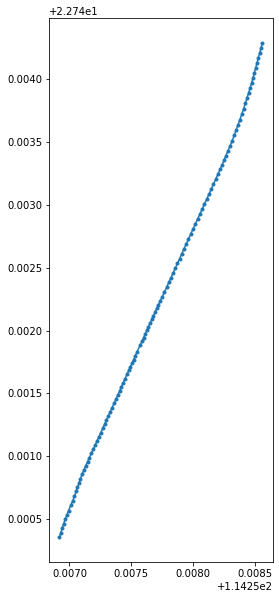

In [5]:
# %matplotlib notebook
plt.figure(figsize=[4,10])
plt.plot(lon, lat,'.-')

Read DAS filenames and parameters

In [6]:
%%time
das_file = glob.glob(datapath+'*.h5')
das_file.sort()

Wall time: 3.99 ms


In [7]:
das_file

['D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000029.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000059.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000129.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000159.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000229.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000259.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000329.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_20230426_000359.053.h5',
 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_f

In [7]:
# # get_das_file_time(das_file[0])

# dp.read_das(das_file[0], metadata='True')

AttributeError: module 'h5py' has no attribute 'File'

Cut tap test events

In [8]:
def read_das_data(filename):
    data= dp.read_das(filename)
    dt = dp.read_das(das_file[0], metadata='True')['dt']
    nt = data.shape[1]
    return data, dt, nt

def get_das_file_time(das_filename, das_name_format):
    return datetime.datetime.strptime(das_filename, das_name_format)

def get_ev_id_in_das_window(event_time_arr, start_time, end_time):
    return np.where((event_time_arr > start_time) & (event_time_arr < end_time))

def get_time_step(start, end, dt):
    return int((start - end).total_seconds() / dt + 1)


def extract_das_data(das_file, das_name_format, ev_time, dt_before, dt_after, save_file_name_prefix, overwrite=False, verbose=False):
    
    das_file_time = np.array([get_das_file_time(das_file[i], das_name_format) for i in range(len(das_file))])
    
    ev_id_in_das_win = get_ev_id_in_das_window(ev_time, das_file_time.min(), das_file_time.max())
    ev_time_in_das_win = ev_time[ev_id_in_das_win]
    
    ev_time_before = ev_time_in_das_win - datetime.timedelta(seconds=dt_before)
    ev_time_after  = ev_time_in_das_win + datetime.timedelta(seconds=dt_after)

    for iev in range(len(ev_id_in_das_win[0])):

        savename = save_file_name_prefix + str(ev_id_in_das_win[0][iev]) + '.npy'
        
        if verbose: print(savename)

        if not (os.path.exists(savename) and not overwrite):

            ins_start = np.searchsorted(das_file_time, ev_time_before[iev:(iev+1)])[0] - 1
            ins_end = np.searchsorted(das_file_time, ev_time_after[iev:(iev+1)])[0]

            das_file_time_select = das_file_time[ins_start:ins_end]
            das_file_select = das_file[ins_start:ins_end]

            ev_t0 = ev_time_before[iev]
            ev_t1 = ev_time_after[iev]

            data = []
            for i in range(len(das_file_select)):
#                 print(das_file_select[i])

                datatmp, dt, nt = read_das_data(das_file_select[i])
                istart, iend = 0, np.copy(nt)

                das_t0 = das_file_time_select[i]
                das_t1 = das_t0 + datetime.timedelta(seconds=dt*nt)

                if ev_t0 > das_t0:
                    istart = get_time_step(ev_t0, das_t0, dt)

                if ev_t1 < das_t1:
                    iend = get_time_step(ev_t1, das_t0, dt)

                data.append(datatmp[:, istart:iend])

            data = np.concatenate(data, axis=1)
            if (data.size > 0):
                np.save(savename, data.astype('float32'))

In [9]:
%%time

das_name_format = 'D:\\博士\\光纤地震学\\龙岗0426\\longgang_metro_20230426\\longgang_metro_GL_5m_frq_1kHz_sp_05m_UTC_%Y%m%d_%H%M%S.%f.h5'

dt_before, dt_after = 0, 10

save_file_name_prefix = workpath + 'longgang_TBM_rtk_'

extract_das_data(das_file, das_name_format, hs_time, dt_before, dt_after, 
                 save_file_name_prefix, overwrite=True, verbose=True)

D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_0.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_1.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_2.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_3.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_4.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_5.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_6.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_7.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_8.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_9.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_10.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_11.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_12.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_13.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_14.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_15.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_16.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_17.npy
D:\博士\光纤地震学\龙岗0426\l

In [12]:
def bandpass(data, dt, fl, fh):
    fs=1/dt
    sos = signal.butter(6, [fl/(fs/2), fh/(fs/2)], 'bp', output='sos')
    data = signal.sosfiltfilt(sos, data, axis=1)
    return data


<IPython.core.display.Javascript object>


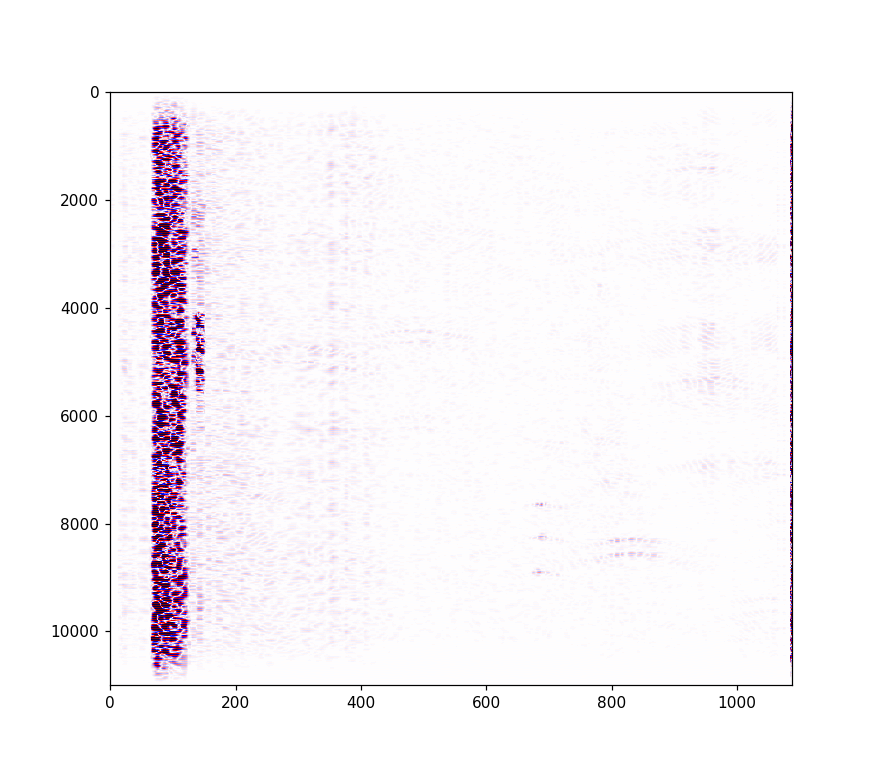

D:\sustech_dir\longgang_TBM_2\tap_test\longgang_TBM_rtk_60.npy


In [71]:
# fig, ax = plt.subplots(figsize=[8,7])

# iev = 60

# savename = save_file_name_prefix + str(iev) + '.npy'

# dt = 1./1000.
# print(savename)
# data = np.load(savename)

# data = dp.das_preprocess(data)


# data = dp.das_preprocess(data)
# f1, f2 = 20, 499
# data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)

# clim = data.std() 

# ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
#            vmin = -clim, vmax = clim,)
# #           extent=[0,data.shape[0], data.shape[1]*dt, 0])


D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_80.npy


<IPython.core.display.Javascript object>


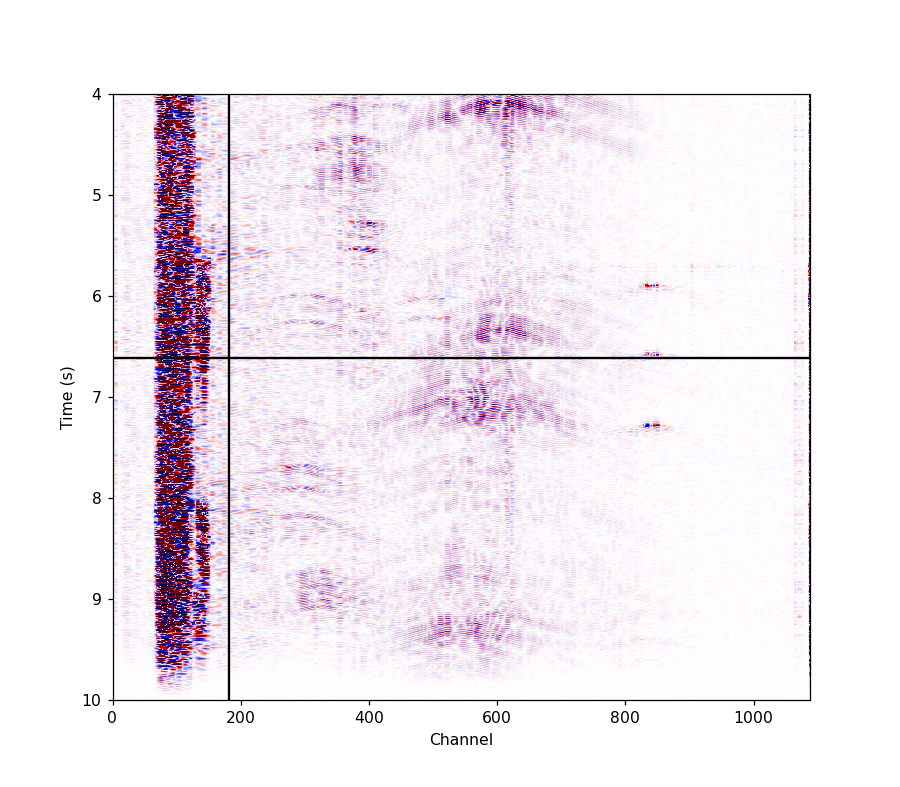

In [13]:
%matplotlib notebook

import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal

save_file_name_prefix = workpath + 'longgang_TBM_rtk_'

iev = 80
# if len(list(click_pos.keys()))>0:
#     iev = max(list(click_pos.keys())) + 1
# else:
#     iev = 21

savename = save_file_name_prefix + str(iev) + '.npy'

dt = 1./1000.
print(savename)
data = np.load(savename)

data = dp.das_preprocess(data)
f1, f2 = 20, 499
data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)


# https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
fig, ax = plt.subplots(figsize=[8,7])

clim = data.std() 

ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

ax.set_ylim([10, 4])
ax.set_xlabel('Channel')
ax.set_ylabel('Time (s)')


def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k")
    axx.axvline(x=event.xdata, color="k")
    
def onMouseClick(event, axx):
    click_pos[iev] = (event.xdata, event.ydata)
    axx.scatter(x=event.xdata, y=event.ydata)

def visualize(i):
#     line1.set_ydata(val1)
    return None
    

click = das_mp.Click(ax, onMouseClick, button=1)
mm    = das_mp.MouseMove(ax, onMouseMove)

ani = animation.FuncAnimation(fig, visualize, interval=1)

plt.axvline(iev*4/0.5+ 128)

plt.show()

In [14]:
%%time


rms_all = []

dt = 1./1000.

for iev in range(110):

    savename = save_file_name_prefix + str(iev) + '.npy'

    
    print(savename)
    data = np.load(savename)

    data = dp.das_preprocess(data)
    f1, f2 = 20, 499
    data = bandpass(data * signal.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)

    rms = np.sqrt((data[:,:]**2).mean(axis=1))
    
    rms_all.append(rms)

D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_0.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_1.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_2.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_3.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_4.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_5.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_6.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_7.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_8.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_9.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_10.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_11.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_12.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_13.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_14.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_15.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_16.npy
D:\博士\光纤地震学\龙岗0426\locate_temp\longgang_TBM_rtk_17.npy
D:\博士\光纤地震学\龙岗0426\l

In [15]:
rms_all = np.asarray(rms_all)

<IPython.core.display.Javascript object>


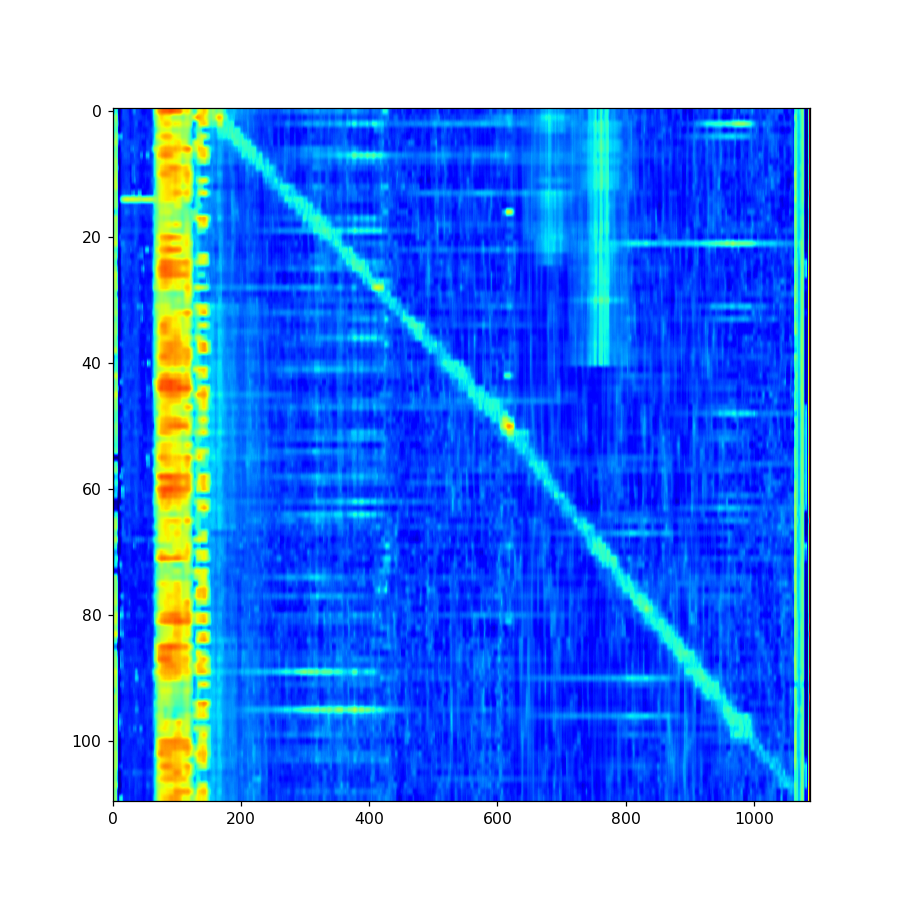

In [16]:
plt.figure(figsize=[8,8])
plt.imshow(np.log10(rms_all), aspect='auto', cmap='jet')
plt.show()

In [17]:
click_pos = {}

<IPython.core.display.Javascript object>


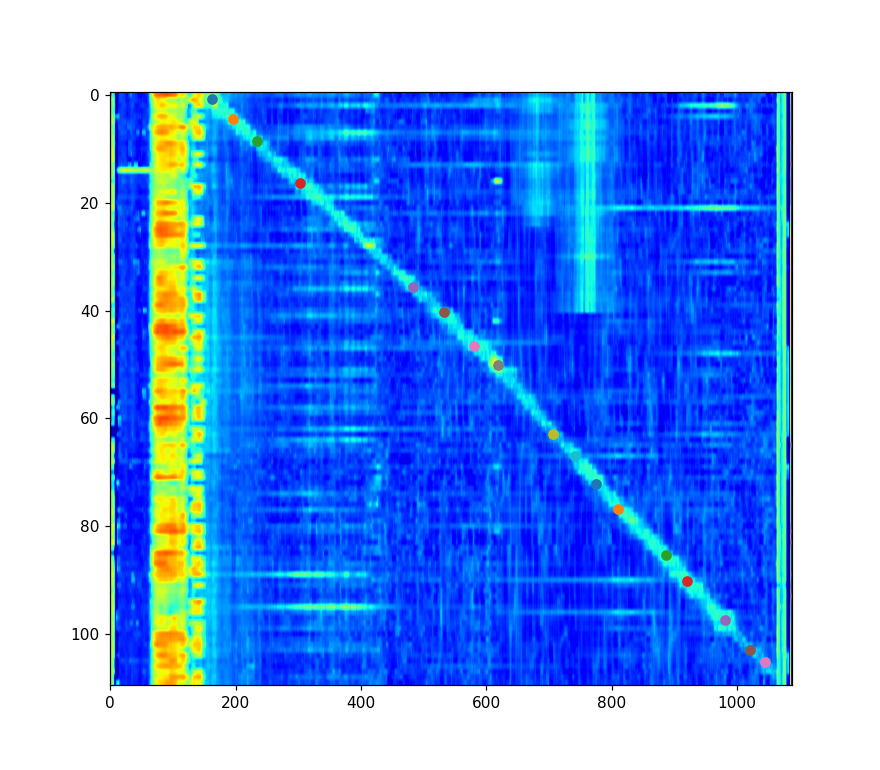

In [90]:
%matplotlib notebook

import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal

fig, ax = plt.subplots(figsize=[8,7])
ax.imshow(np.log10(rms_all), aspect='auto', cmap='jet')



def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k")
    axx.axvline(x=event.xdata, color="k")
    
def onMouseClick(event, axx):
    click_pos[int(event.ydata)] = event.xdata
    axx.scatter(x=event.xdata, y=event.ydata)

def visualize(i):
#     line1.set_ydata(val1)
    return None
    

click = das_mp.Click(ax, onMouseClick, button=1)
mm    = das_mp.MouseMove(ax, onMouseMove)

ani = animation.FuncAnimation(fig, visualize, interval=1)

plt.show()

In [101]:
click_pos

{0: 162.14668598790323,
 4: 195.48862147177417,
 8: 234.0950730846774,
 16: 302.53378276209673,
 35: 483.28216985887093,
 40: 532.4176537298387,
 46: 579.798298891129,
 50: 618.4047505040322,
 62: 706.1466859879032,
 67: 741.2434601814515,
 72: 774.5853956653225,
 76: 809.6821698588709,
 85: 886.8950730846773,
 90: 920.2370085685484,
 97: 979.9015246975805,
 102: 1020.2628150201613,
 105: 1044.830556955645}

In [102]:
irtk, ichn = [], []
for i in click_pos.keys():
    irtk.append(int(i))
    ichn.append(click_pos[i])
    
irtk = np.array(irtk)
ichn = np.array(ichn)

In [103]:
irtk

array([  0,   4,   8,  16,  35,  40,  46,  50,  62,  67,  72,  76,  85,
        90,  97, 102, 105])

In [104]:
ichn

array([ 162.14668599,  195.48862147,  234.09507308,  302.53378276,
        483.28216986,  532.41765373,  579.79829889,  618.4047505 ,
        706.14668599,  741.24346018,  774.58539567,  809.68216986,
        886.89507308,  920.23700857,  979.9015247 , 1020.26281502,
       1044.83055696])

In [114]:
from sklearn.linear_model import LinearRegression


def lat_lon_dep_to_interval(lat, lon, dep):

    dL = np.sqrt(np.diff(lat)**2 + np.diff(lon)**2, np.diff(dep)**2)
    return dL

def linRegModel(x,y):
    return LinearRegression().fit(x.reshape(-1,1), y)

def interpolate_lat_lon_dep(ch2rtk, rtk_hit_chn, rtk_length, lat, lon, dep):
    x_ch = np.arange(int(rtk_hit_chn.min())-50, int(rtk_hit_chn.max())+50)
    x_rtk = ch2rtk.predict(x_ch.reshape(-1,1))

    xch_min, xch_max = np.argwhere(x_rtk<rtk_length[0]).max(), np.argwhere(x_rtk>rtk_length[-1]).min()
   
    x_lat = np.interp(x_rtk, rtk_length, lat)[xch_min:xch_max]
    x_lon = np.interp(x_rtk, rtk_length, lon)[xch_min:xch_max]
    x_dep = np.interp(x_rtk, rtk_length, dep)[xch_min:xch_max]
    x_chn = x_ch[xch_min:xch_max]
    
    return x_chn, x_lat, x_lon, x_dep

In [115]:
rtk_hit_chn = ichn

rtk_dL = lat_lon_dep_to_interval(lat, lon, dep)
rtk_length = np.r_[0, rtk_dL].cumsum()

ch2rtk = linRegModel(rtk_hit_chn, rtk_length[irtk])

x_chn, x_lat, x_lon, x_dep = interpolate_lat_lon_dep(ch2rtk, rtk_hit_chn, rtk_length[irtk], 
                                                     lat[irtk], lon[irtk], dep[irtk])

<IPython.core.display.Javascript object>


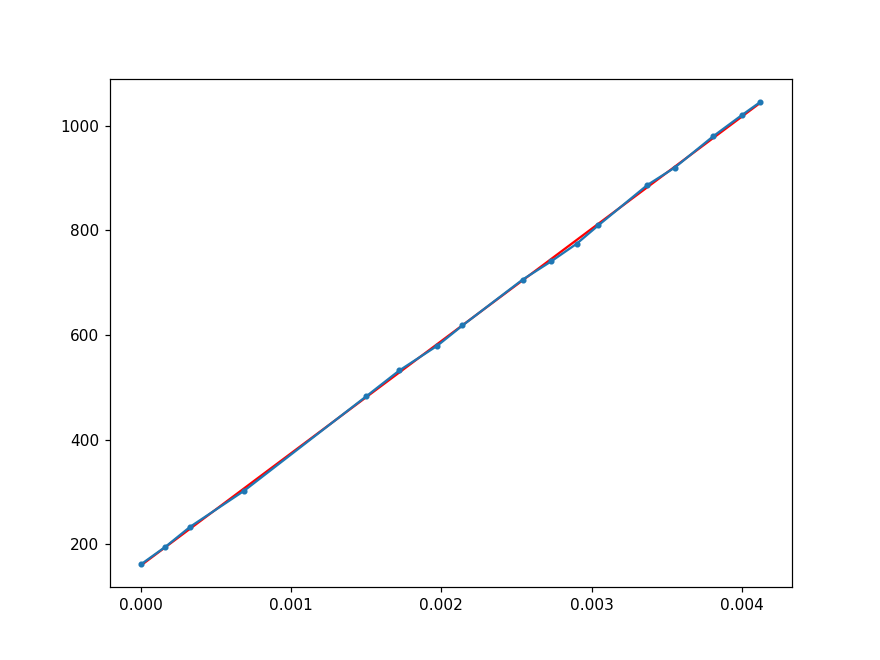

In [116]:
%matplotlib notebook
plt.figure(figsize=[8,6])
plt.plot(ch2rtk.predict(rtk_hit_chn.reshape(-1,1)), rtk_hit_chn, 'r-')
plt.plot(rtk_length[irtk], rtk_hit_chn, '.-')

<IPython.core.display.Javascript object>


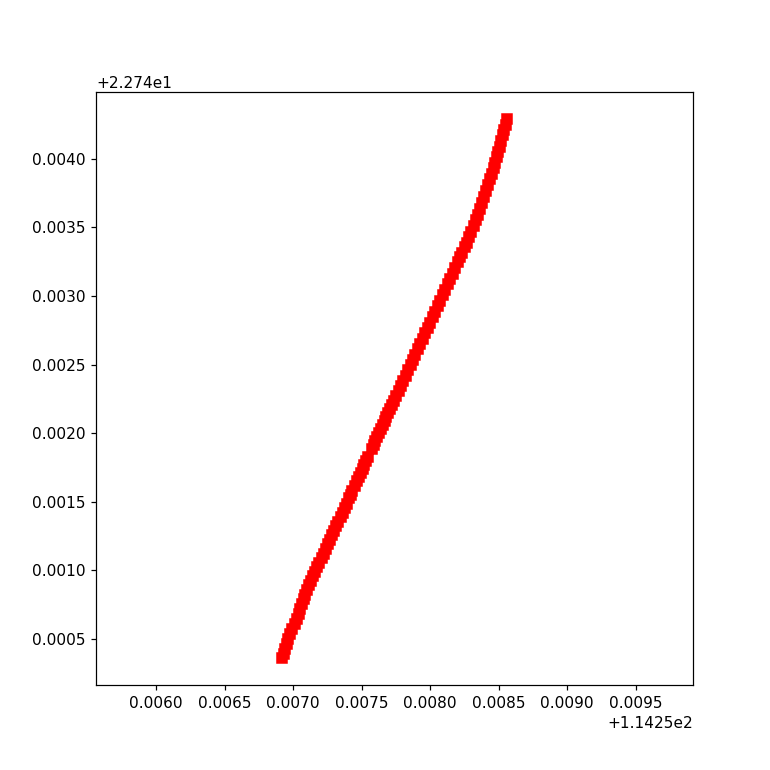

In [120]:
plt.figure(figsize=[7,7])
plt.plot(x_lon, x_lat,'.')
plt.plot(lon, lat, 'rs')
plt.axis('equal')
plt.show()

In [165]:
# np.savetxt('D:\\sustech_dir\\longgang_TBM\\longgang_TBM_ENZ_coordinates.txt', np.stack([x_chn, x_lon, x_lat, x_dep]).T, fmt='%d,%f,%f,%f', delimiter=',')

In [121]:
x_chn.shape

(884,)